# Data preparation

In [1]:
import json
from src.ingestion.download_related_paper_datasets import download_related_paper_datasets
from src.ingestion.download_samples import download_samples
import seaborn as sns
from wordcloud import WordCloud
from io import StringIO
import matplotlib.pyplot as plt
from src.analysis.analyzer import DatasetAnalyzer
from src.visualization.visualize_clusters import visualize_clusters_jupyter
from src.visualization.get_topic_table import get_topic_table
import aiohttp
import asyncio
import pandas as pd
import itertools
import spacy
import scispacy
from scispacy.linking import EntityLinker
from src.model.geo_dataset import GEODataset
from src.model.geo_sample import GEOSample
from typing import Tuple, List, Dict
from dateutil.parser import parse as parse_date
import datetime

{"asctime": "2025-06-11 17:31:27,433", "levelname": "INFO", "message": "Registering at the factory, space: dummy distance type: INT"}
{"asctime": "2025-06-11 17:31:27,434", "levelname": "INFO", "message": "Registering at the factory, space: dummy distance type: FLOAT"}
{"asctime": "2025-06-11 17:31:27,434", "levelname": "INFO", "message": "Registering at the factory, space: bit_hamming distance type: INT"}
{"asctime": "2025-06-11 17:31:27,435", "levelname": "INFO", "message": "Registering at the factory, space: bit_jaccard distance type: FLOAT"}
{"asctime": "2025-06-11 17:31:27,435", "levelname": "INFO", "message": "Registering at the factory, space: leven distance type: INT"}
{"asctime": "2025-06-11 17:31:27,436", "levelname": "INFO", "message": "Registering at the factory, space: normleven distance type: FLOAT"}
{"asctime": "2025-06-11 17:31:27,436", "levelname": "INFO", "message": "Registering at the factory, space: kldivfast distance type: FLOAT"}
{"asctime": "2025-06-11 17:31:27,4

In [2]:
paper_export = json.load(open("GEO_Datasets/pubmed-hallmarks-of-aging-an-expanding-universe.json"))
datasets = download_related_paper_datasets(paper_export)
print(len(datasets))

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/src/ingestion/download_related_paper_datasets.py:15: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(paper_export["df"])


371


# Dataset metadata

## Experiment types

In [3]:
experiment_types = [dataset.experiment_type for dataset in datasets]
print(experiment_types[0:10])

['Expression profiling by high throughput sequencing', 'Methylation profiling by genome tiling array', 'Expression profiling by high throughput sequencing', 'Other', 'Expression profiling by high throughput sequencing', 'Expression profiling by array', 'Expression profiling by array', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing']


/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 9.444444444444438, 'Count')

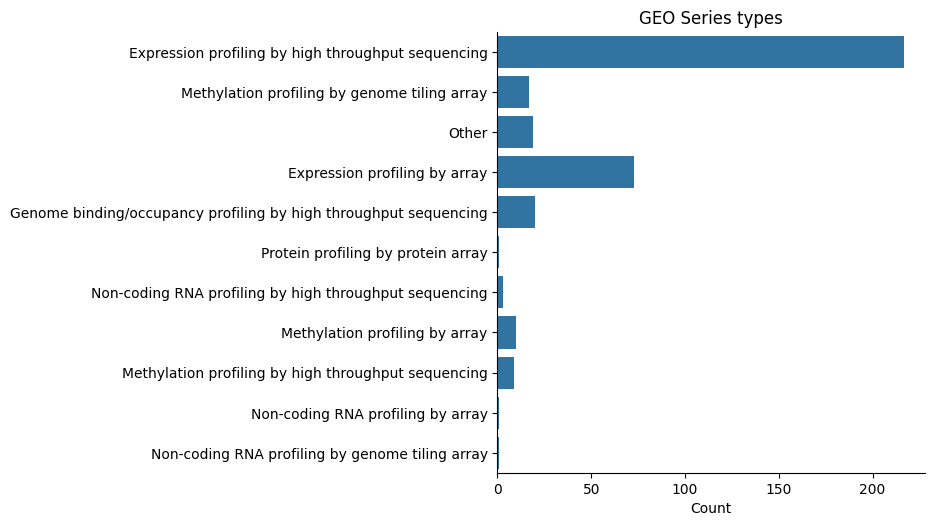

In [4]:
sns.catplot(experiment_types, kind="count")
plt.title("GEO Series types")
plt.xlabel("Count")

Most experiments are done through expression profiling by high throughput sequencing.

## Organisms

In [5]:
def replace_low_frequency_levels_with_other(pd_series, threshold):
    value_counts = pd_series.value_counts()
    low_freq_categories = value_counts[value_counts < threshold].index

    # Replace low-frequency categories with "Other"
    return pd_series.where(~pd_series.isin(low_freq_categories), 'Other')

49


Text(0.5, 9.444444444444438, '# Series')

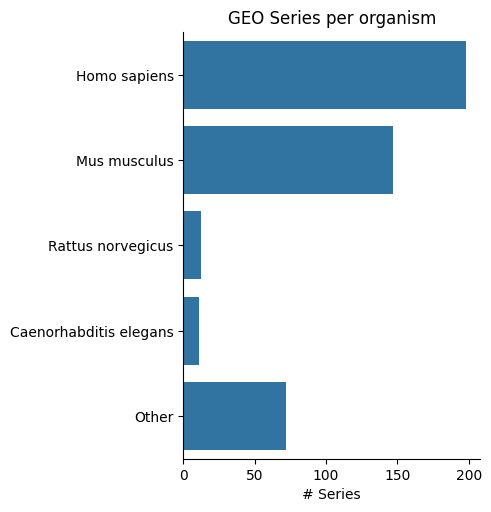

In [6]:
organisms = [organism for dataset in datasets for organism in dataset.organisms]
print(len(set(organisms)))
organisms = pd.Series(organisms)
organisms = replace_low_frequency_levels_with_other(organisms, 10)
sns.catplot(organisms, kind="count", order=["Homo sapiens", "Mus musculus", "Rattus norvegicus", "Caenorhabditis elegans", "Other"])
plt.title("GEO Series per organism")
plt.xlabel("# Series")

Most datasets are collected from either mice or people.

In [7]:
## Title wordcolud

In [8]:
from typing import List
def plot_wordcloud(strings: List[str]):
    """
    Plots a wordcloud of a list of strings.
    """
    si = StringIO()
    for string in strings:
        si.write(string)
    text = si.getvalue()
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white",max_words=len(text),max_font_size=40,).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

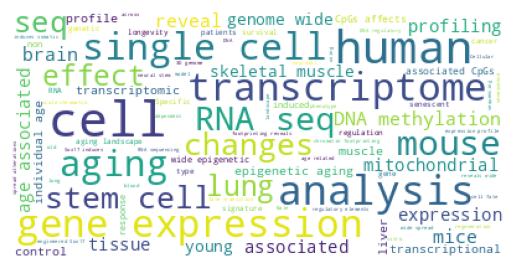

In [9]:
plot_wordcloud([dataset.title for dataset in datasets])

## Summary wordcolud

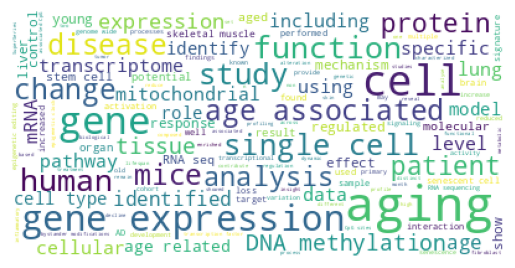

In [10]:
plot_wordcloud([dataset.summary for dataset in datasets])


## Overall design wordcolud

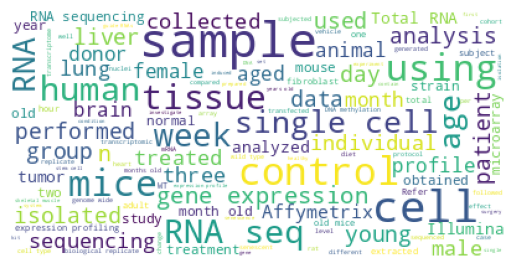

In [11]:
plot_wordcloud([dataset.overall_design for dataset in datasets])

## Platform ID counts

<Figure size 1000x2000 with 0 Axes>

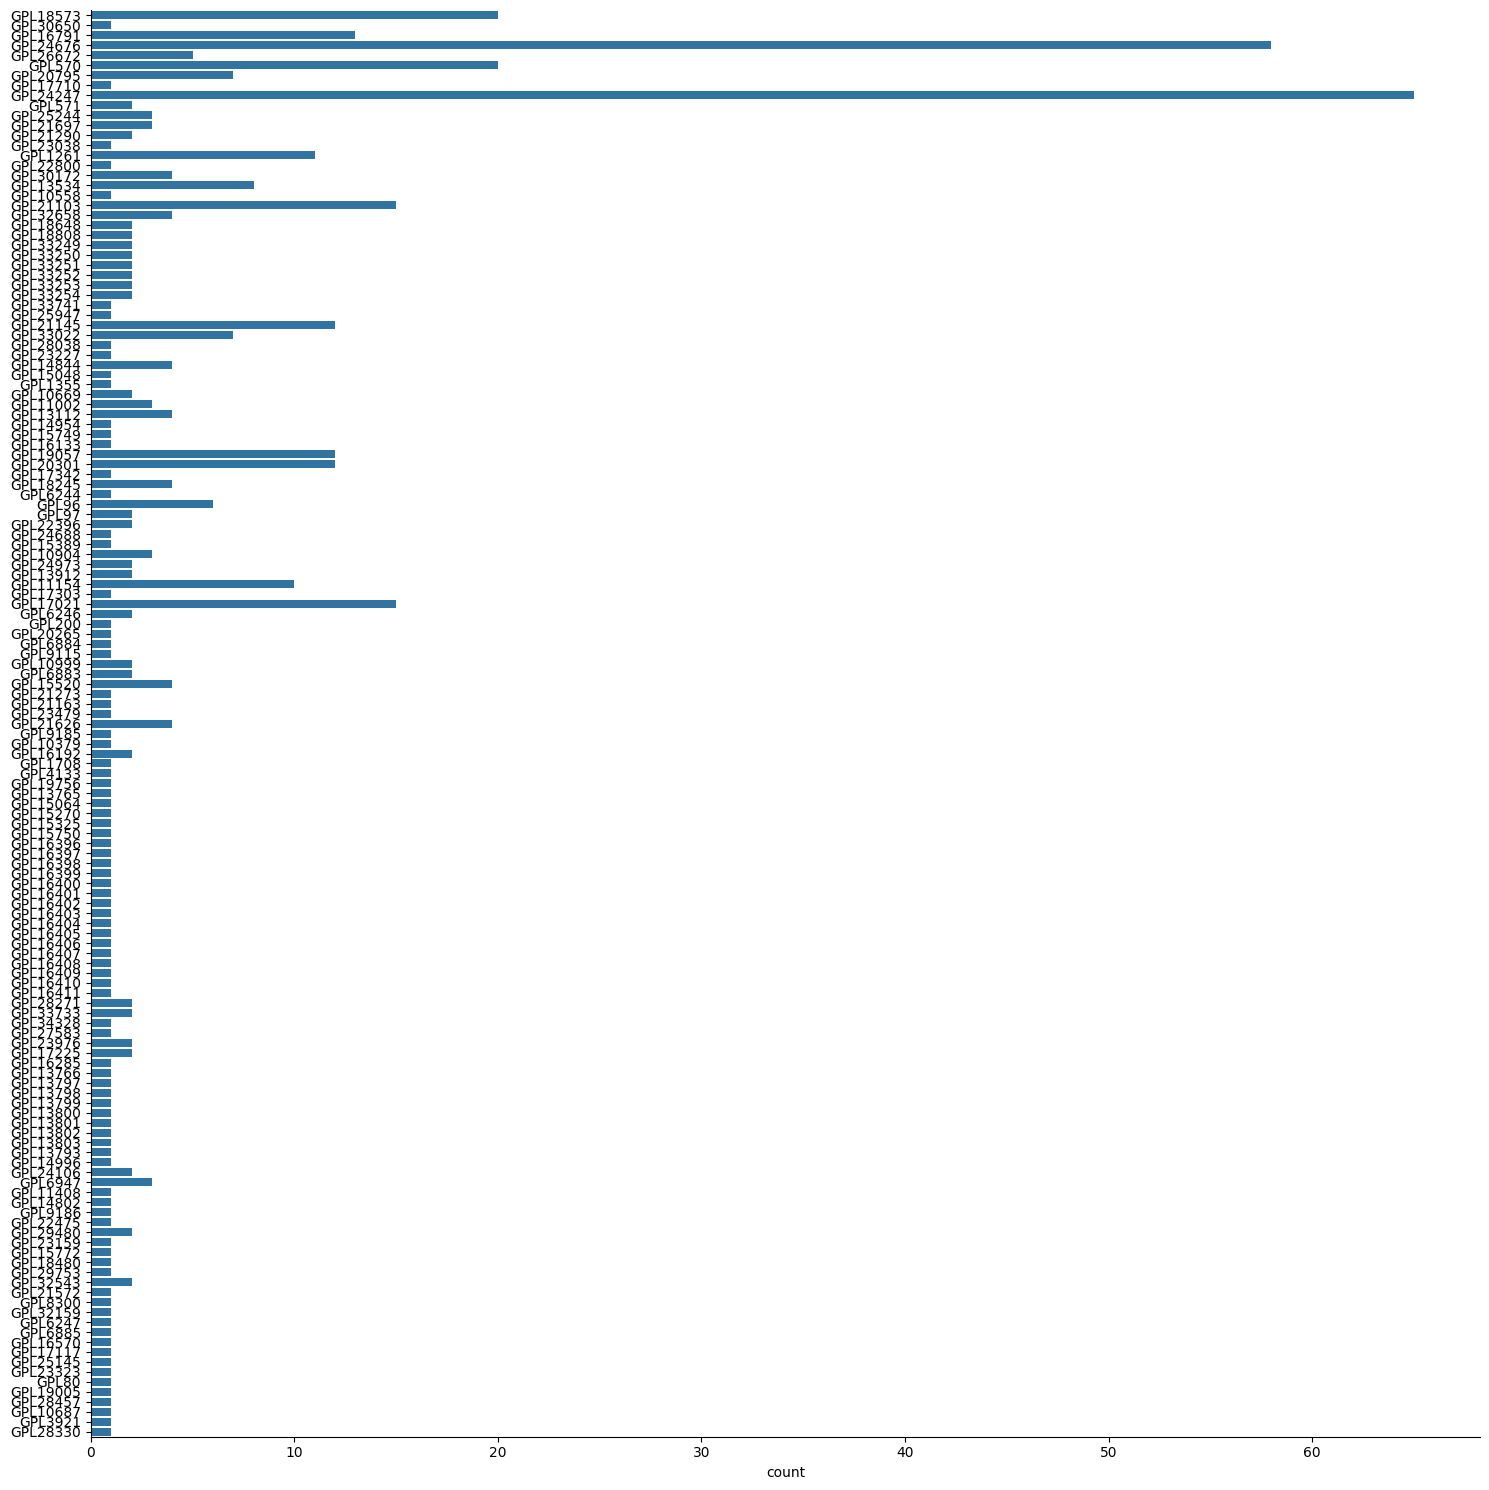

In [12]:
platform_ids = [platform_id for dataset in datasets for platform_id in dataset.platform_ids]
plt.figure(figsize=(10, 20))
sns.catplot(platform_ids, kind="count", height=15)
plt.show()

The top two platform IDs correspond to the Illumina Nova Seq 6000 sequencer. There is one platform record for when it is used and people and another one for mice. This is not surprising as Illumina sequencers are widely used in genomics research.

## Publication date

{"asctime": "2025-06-11 17:31:33,976", "levelname": "INFO", "message": "Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting."}
{"asctime": "2025-06-11 17:31:33,980", "levelname": "INFO", "message": "Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting."}


<Axes: title={'center': 'Datasets per year'}, xlabel='Year', ylabel='Number of datasets'>

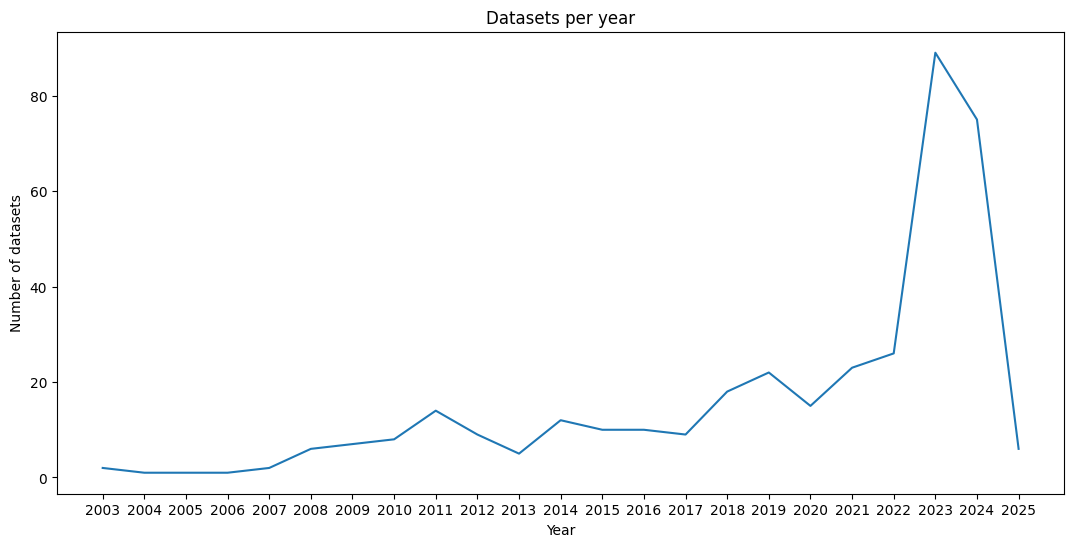

In [13]:
years = [str(dataset.publication_date.year) for dataset in datasets]
years = pd.DataFrame(years, columns=["year"])
years = years.groupby(["year"], as_index=False).agg(count=("year", "count"))
fig, ax = plt.subplots(figsize=(13, 6))
plt.title("Datasets per year")
plt.xlabel("Year")
plt.ylabel("Number of datasets")
sns.lineplot(years, x="year", y="count", ax=ax)

## Country

<Axes: title={'center': 'Number of datasets from each country'}, xlabel='count'>

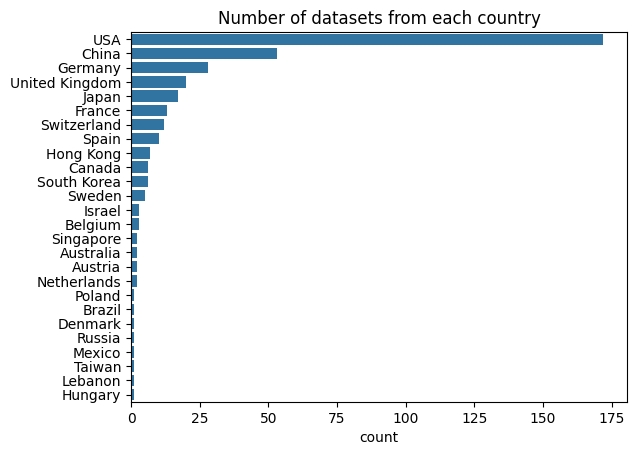

In [14]:
countries = pd.Series([dataset.metadata["contact_country"][0] for dataset in datasets])
plt.title("Number of datasets from each country")
sns.countplot(countries, order=countries.value_counts().index)

# Clustering

In [15]:
svd_dimensions = 15
topic_words = 10
best_result = None
best_score = -1
best_n_clusters = None

for n_clusters in range(5, 20):
    analyzer = DatasetAnalyzer(svd_dimensions, n_clusters)
    result = analyzer.analyze_datasets(datasets)
    if result.silhouette_score > best_score:
        best_score = result.silhouette_score
        best_result = result
        best_n_clusters = n_clusters

print(f"Best number of clusters {best_n_clusters}")

{"asctime": "2025-06-11 17:31:34,346", "levelname": "INFO", "message": "Explained variance of the SVD step: 19.5 %"}
{"asctime": "2025-06-11 17:31:34,370", "levelname": "INFO", "message": "Silhouette score: 0.1627563226802607"}
{"asctime": "2025-06-11 17:31:34,373", "levelname": "INFO", "message": "Clustering time: 0.02s"}
{"asctime": "2025-06-11 17:31:35,192", "levelname": "INFO", "message": "Explained variance of the SVD step: 19.5 %"}
{"asctime": "2025-06-11 17:31:35,217", "levelname": "INFO", "message": "Silhouette score: 0.19175802352564078"}
{"asctime": "2025-06-11 17:31:35,220", "levelname": "INFO", "message": "Clustering time: 0.02s"}
{"asctime": "2025-06-11 17:31:36,068", "levelname": "INFO", "message": "Explained variance of the SVD step: 19.5 %"}
{"asctime": "2025-06-11 17:31:36,093", "levelname": "INFO", "message": "Silhouette score: 0.21413254917967003"}
{"asctime": "2025-06-11 17:31:36,094", "levelname": "INFO", "message": "Clustering time: 0.02s"}
{"asctime": "2025-06-11

Similar datasets are located close to each other.
The color of a point represnts the topic of the dataset.

In [16]:
visualize_clusters_jupyter(best_result.df, best_result.cluster_topics)

Loading BokehJS ...

## Topics

In [17]:
topic_table = get_topic_table(best_result.cluster_topics, best_result.df)
topic_df = pd.DataFrame(topic_table, columns=["#", "Datasets", "Color", "Topics"])
topic_df = topic_df.set_index("#")
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Apply styling to the 'color' column
topic_df = topic_df[["Color", "Datasets", "Topics"]].style.map(lambda x: f"background-color: {x};" if type(x) == str and x.startswith("#") else "")\
    .map(lambda x: f"color: {x};" if type(x) == str and x.startswith("#") else "")
topic_df

,Color,Datasets,Topics
#,,,
1,#1f77b4,58,"cell, single, cells, human, seq, aging, stem, tissue, lung, musculus"
2,#aec7e8,53,"brain, aged, aging, young, old, transcriptome, adult, mrna, mouse, analysis"
3,#ff7f0e,49,"patients, cancer, lung, gene, array, tumor, non, molecular, data, disease"
4,#ffbb78,34,"senescent, senescence, cells, stress, sasp, induced, cellular, profile, treatment, known"
5,#2ca02c,30,"mice, months, parabiosis, mouse, liver, week, collected, diet, animals, weeks"
6,#98df8a,29,"muscle, skeletal, subjects, mice, dnmt3a, biopsies, older, overexpression, regulation, healthy"
7,#d62728,25,"chromatin, ad, hippocampus, female, male, accessibility, dependent, binding, alzheimer, cellular"
8,#ff9896,23,"mitochondrial, lifespan, protein, daf, elegans, ageing, aal1, translation, longevity, ribosome"
9,#9467bd,22,"methylation, dna, blood, schizophrenia, controls, genome, study, samples, cases, illumina"


# Sample metadata

In [18]:
# Download samples
samples = set() # We are using a set because some samples can occur twice. For example, a sample appears twice when it is in a subseries and superseries
async with aiohttp.ClientSession() as session:
    for series in datasets:
        try:
            series.samples = await download_samples(series, session)
            samples.update(series.samples)
        except aiohttp.ServerDisconnectedError:
            session = await session.close()
            session = aiohttp.ClientSession()
            series.samples = await download_samples(series, session)
            samples.update(series.samples)

accessions = [sample.accession for sample in samples]
assert len(set(accessions)) == len(samples)

## Number of samples

In [19]:
len(samples)

44591

## Number of samples per dataset

Mean: 125.02156334231806
Median: 12


Text(0.5, 1.0, 'Number of samples per dataset')

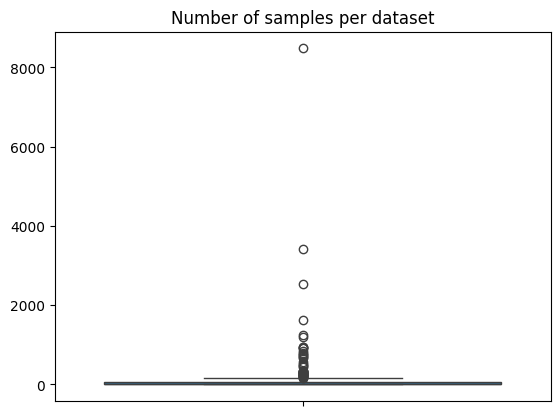

In [20]:
number_of_samples_per_dataset = [len(dataset.samples) for dataset in datasets]
print("Mean:", sum(number_of_samples_per_dataset) / len(number_of_samples_per_dataset))
print("Median:", number_of_samples_per_dataset[len(number_of_samples_per_dataset) // 2])
sns.boxplot(number_of_samples_per_dataset)
plt.title("Number of samples per dataset")

## Most common sample types

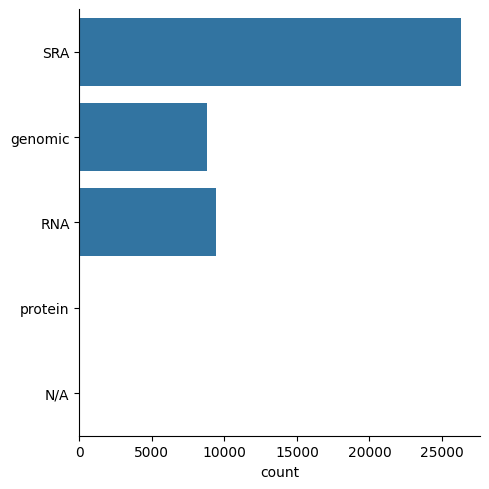

In [21]:
sample_types = [sample.sample_type for sample in samples]
sns.catplot(sample_types, kind="count")

## Most common characteristics keys

In [22]:
def remove_low_frequency_levels(pd_series, threshold):
    value_counts = pd_series.value_counts()
    low_freq_categories = value_counts[value_counts < threshold].index
    return pd_series[~pd_series.isin(low_freq_categories)]

Text(0.5, 1.0, 'Most common characterisitics keys')

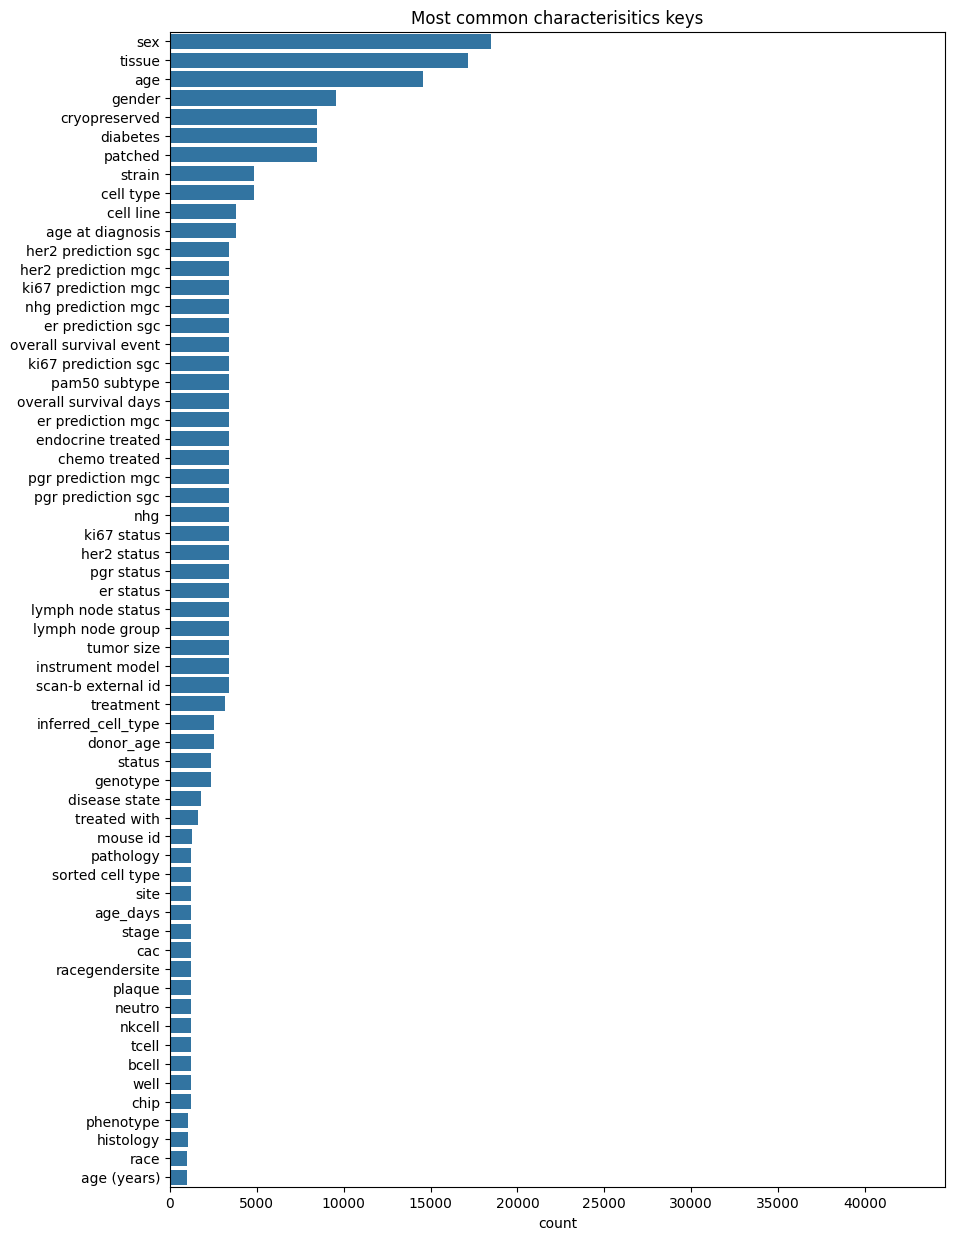

In [23]:
characteristics_keys = pd.Series([key for sample in samples for key in sample.characteristics])
characteristics_keys = remove_low_frequency_levels(characteristics_keys, 1000)
fig, ax = plt.subplots(figsize=(10, 15))
ax.set_xlim(0, len(samples))
sns.countplot(characteristics_keys, ax=ax, order=characteristics_keys.value_counts().index)
ax.set_title("Most common characterisitics keys")

In [24]:
# Version with fewer items
characteristics_keys = pd.Series([key for sample in samples for key in sample.characteristics])
characteristics_keys = remove_low_frequency_levels(characteristics_keys, 5000)
ax.set_xlim(0, len(samples))
sns.countplot(characteristics_keys, ax=ax, order=characteristics_keys.value_counts().index)
ax.set_title("Most common characterisitics keys")

Text(0.5, 1.0, 'Most common characterisitics keys')

In [25]:
pd.Series(characteristics_keys).value_counts().head(10)

sex              18506
tissue           17161
age              14562
gender            9548
cryopreserved     8477
diabetes          8477
patched           8477
Name: count, dtype: int64

## Number of samples that have data tables

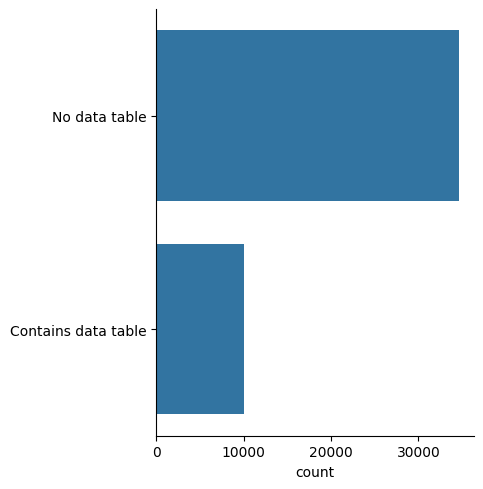

In [26]:
contains_data_table = ["Contains data table" if "data_row_count" in sample.metadata and sample.metadata["data_row_count"][0] != "0" else "No data table" for sample in samples]
sns.catplot(contains_data_table, kind="count")

It seems that relatively few samples have data tables. Therefore, most data is raw sequencing data. 

## Most common tissues

Text(0.5, 1.0, 'Number of samples per tissue')

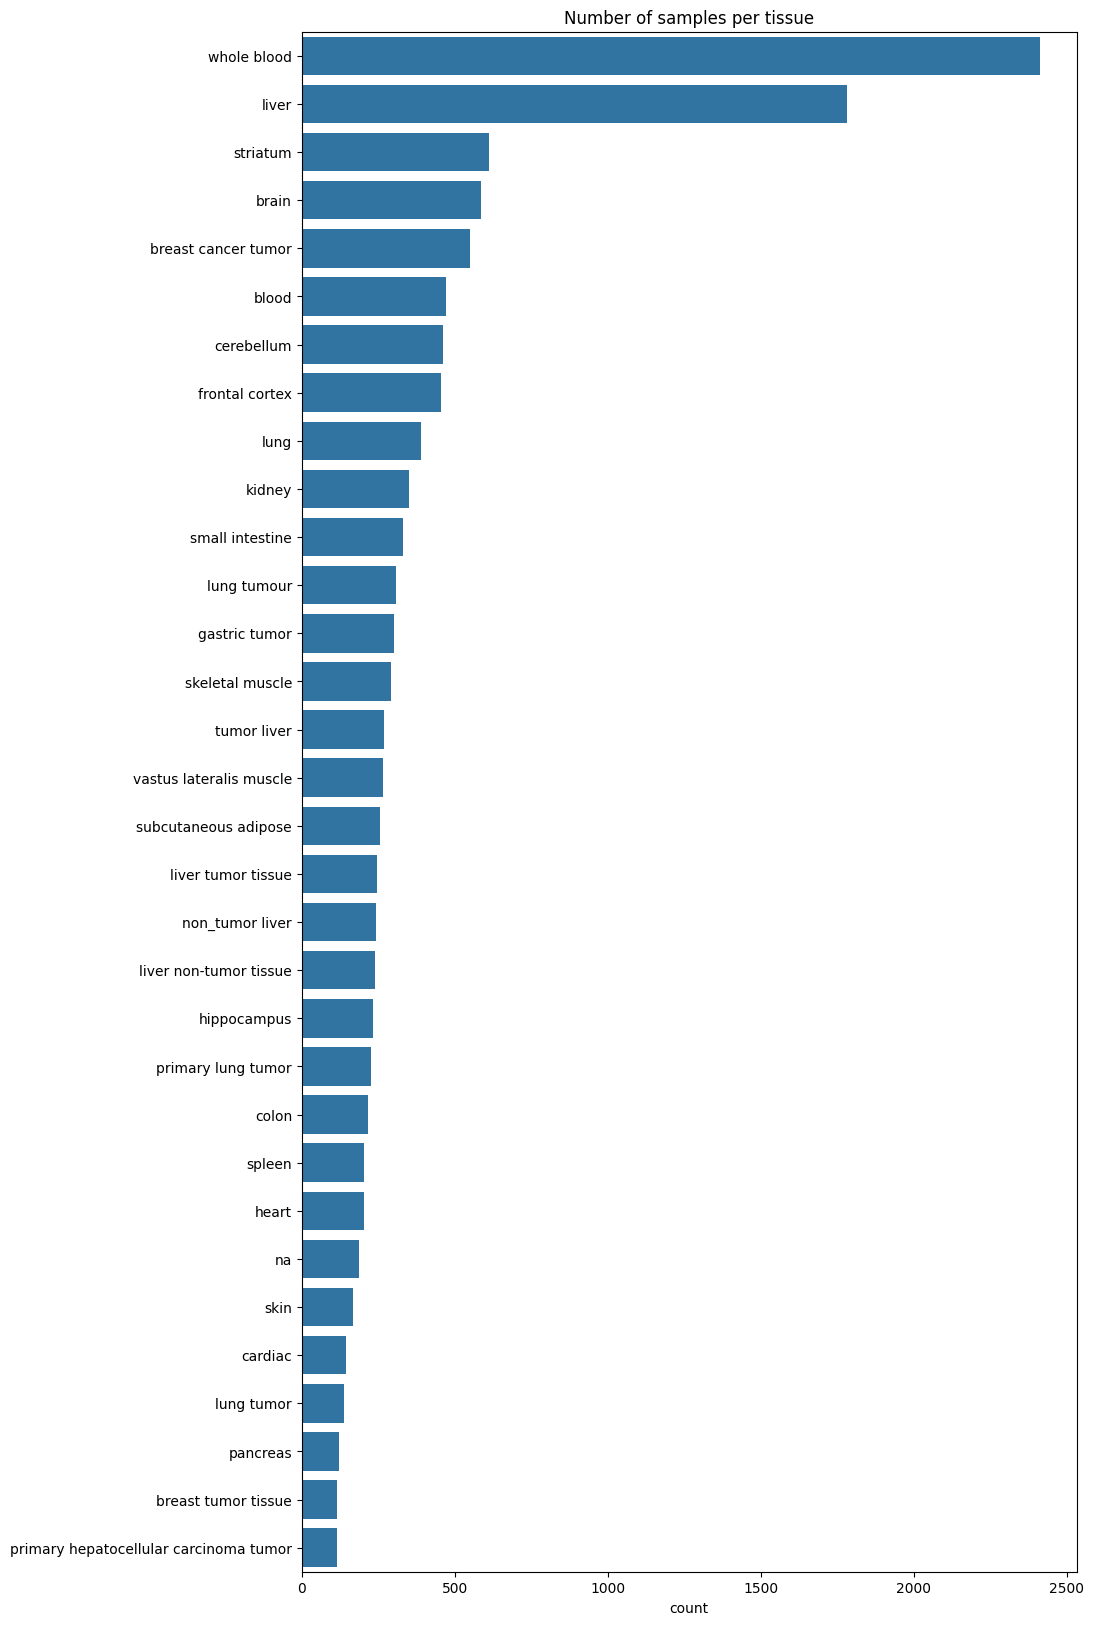

In [27]:
tissues = pd.Series([sample.characteristics["tissue"] for sample in samples if "tissue" in sample.characteristics])
tissues_processed = remove_low_frequency_levels(tissues, 100)
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(tissues_processed, ax=ax, order=tissues_processed.value_counts().index)
ax.set_title("Number of samples per tissue")

There are different names for the same tissue depending on how specific the author wanted to be. Let's try grouping the synonyms together.

The following groupings were obtained using LLama.3.3-70B with the following prompt:

Here is a list of tissue names as extracted from Gene Expression Omnibus sample records. There are different names for the same kind of tissue in the list. Group the synonymous tissue names and give the group a meaningful name. If there are no synonyms for a tissue type create a new group for each such tissue ("<tissue>": ["<tissue>"]). Do not create a category name like "Other". Make sure every item in the list is covered.

Output a JSON where the keys are the group names and the values are the synonyms in that group.

List of tissue names: \<python list of tissue names\>

In [28]:
synonym_groups = \
{
    "Fibroblasts": [
        "Dermal Fibroblast",
        "Fibroblast",
        "Fibroblasts",
        "Human Fibroblast",
        "Human embryonic lung fibroblasts",
        "Mouse embryonic fibroblast",
        "Mouse embryonic fibroblasts",
        "old fibroblasts",
        "Primary lung fibroblasts"
    ],
    "Neural Stem Cells": [
        "fetal primary NSC",
        "miNSC",
        "NSC",
        "old NSC",
        "old miNSC",
        "Primary neural stem cells"
    ],
    "Lung Cells": [
        "Lung cells",
        "mix cell types from lung"
    ],
    "Hepatocytes": [
        "hepatoma cell",
        "Hepatocyte",
        "hepatocellular carcinoma",
        "liver"
    ],
    "Mesenchymal Stromal Cells": [
        "Mesenchymal stromal cell",
        "Mesenchymal stromal cells",
        "human Mesenchymal stem cells",
        "mesenchymal stem cells"
    ],
    "Blood Cells": [
        "Bone marrow cells",
        "Bone marrow mononuclear cells",
        "Hematopoietic progenitors",
        "Hematopoietic stem cells",
        "leukocyte",
        "Peripheral mononuclear blood cell"
    ],
    "Stromal Cells": [
        "CD45-PECAM1+ thymic stroma cells",
        "CD45-PDGFRA+ thymic stroma cells",
        "CD45- thymic stroma cells",
        "Normal human primary prostate stromal cells",
        "stroma cells"
    ],
    "Epithelial Cells": [
        "Conjunctival epithelial cell",
        "corneal epithelial cell"
    ],
    "Muscle Cells": [
        "immortalized mouse myoblast",
        "muscle stem",
        "Pax7+ stem cells"
    ],
    "Immune Cells": [
        "Alveolar Macrophages",
        "B lymphoblastoid",
        "B lymphoblastoid, mouse embryonic stem cell",
        "primary T-cells",
        "T lymphocyte cells"
    ],
    "Yeast Cells": [
        "yeast cells"
    ],
    "Cell Culture": [
        "cell culture",
        "mixed cell culture",
        "mixture"
    ],
    "Brain Cells": [
        "astrocytes",
        "brain",
        "brain cells",
        "microglia",
        "neurons",
        "total brain cells"
    ],
    "Embryonic Stem Cells": [
        "mouse embryonic stem cell"
    ],
    "Podocytes": [
        "podocytes"
    ],
    "Leydig Cells": [
        "Leydig cells"
    ],
    "Endothelial Cells": [
        "Endothelial cells isolation(CD31 positive selection)"
    ],
    "Human Neuronal Cells": [
        "Human nueronal cells"
    ],
    "EPC": [
        "EPC"
    ],
    "NPC": [
        "NPC"
    ],
    "FAPs": [
        "FAPs"
    ],
    "MEF": [
        "MEF",
        "MEFs"
    ],
    "Human Embryonic Kidney": [
        "human embryonic kidney"
    ],
    "Dental Pulp Cell": [
        "Dental pulp cell"
    ],
    "Tissue Dissociated Cells": [
        "tissue dissociated cells"
    ],
    "Reprogramming Intermediate": [
        "Reprogramming intermediate"
    ],
    "Etoposide-induced Senescent Cells": [
        "Etoposide-induced senescent (ETIS) cells"
    ],
    "Carcinoma Cells": [
        "Carcinoma, derived from the metastatic site, bone of a prostate cancer patient",
        "Grade IV, adenocarcinoma, derived from the metastatic site, brain of a prostate cancer patient"
    ]
}

tissue_to_group_mapping = {tissue: group for group, tissue_list in synonym_groups.items() for tissue in tissue_list}

In [29]:
mapped_tissues = [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in tissues]

Text(0.5, 1.0, 'Number of samples per tissue (synonyms grouped)')

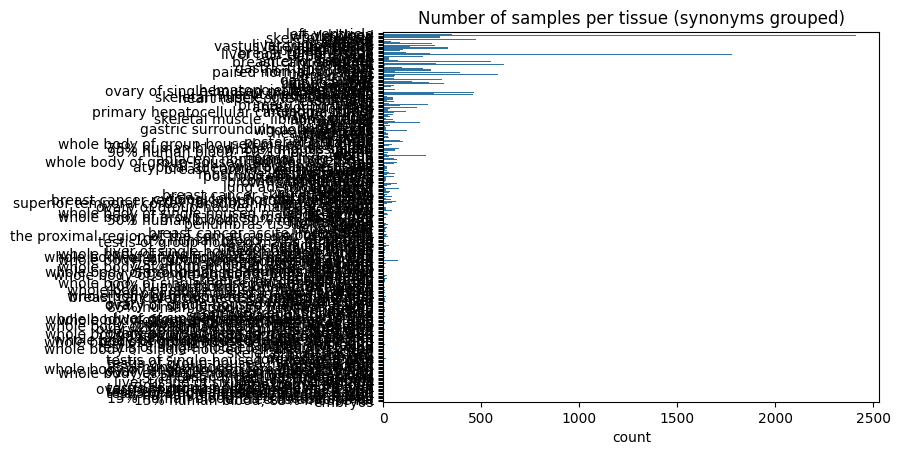

In [30]:
ax = sns.countplot(mapped_tissues)
ax.set_title("Number of samples per tissue (synonyms grouped)")

## Most common cell types

Text(0.5, 1.0, 'Number of samples per cell type')

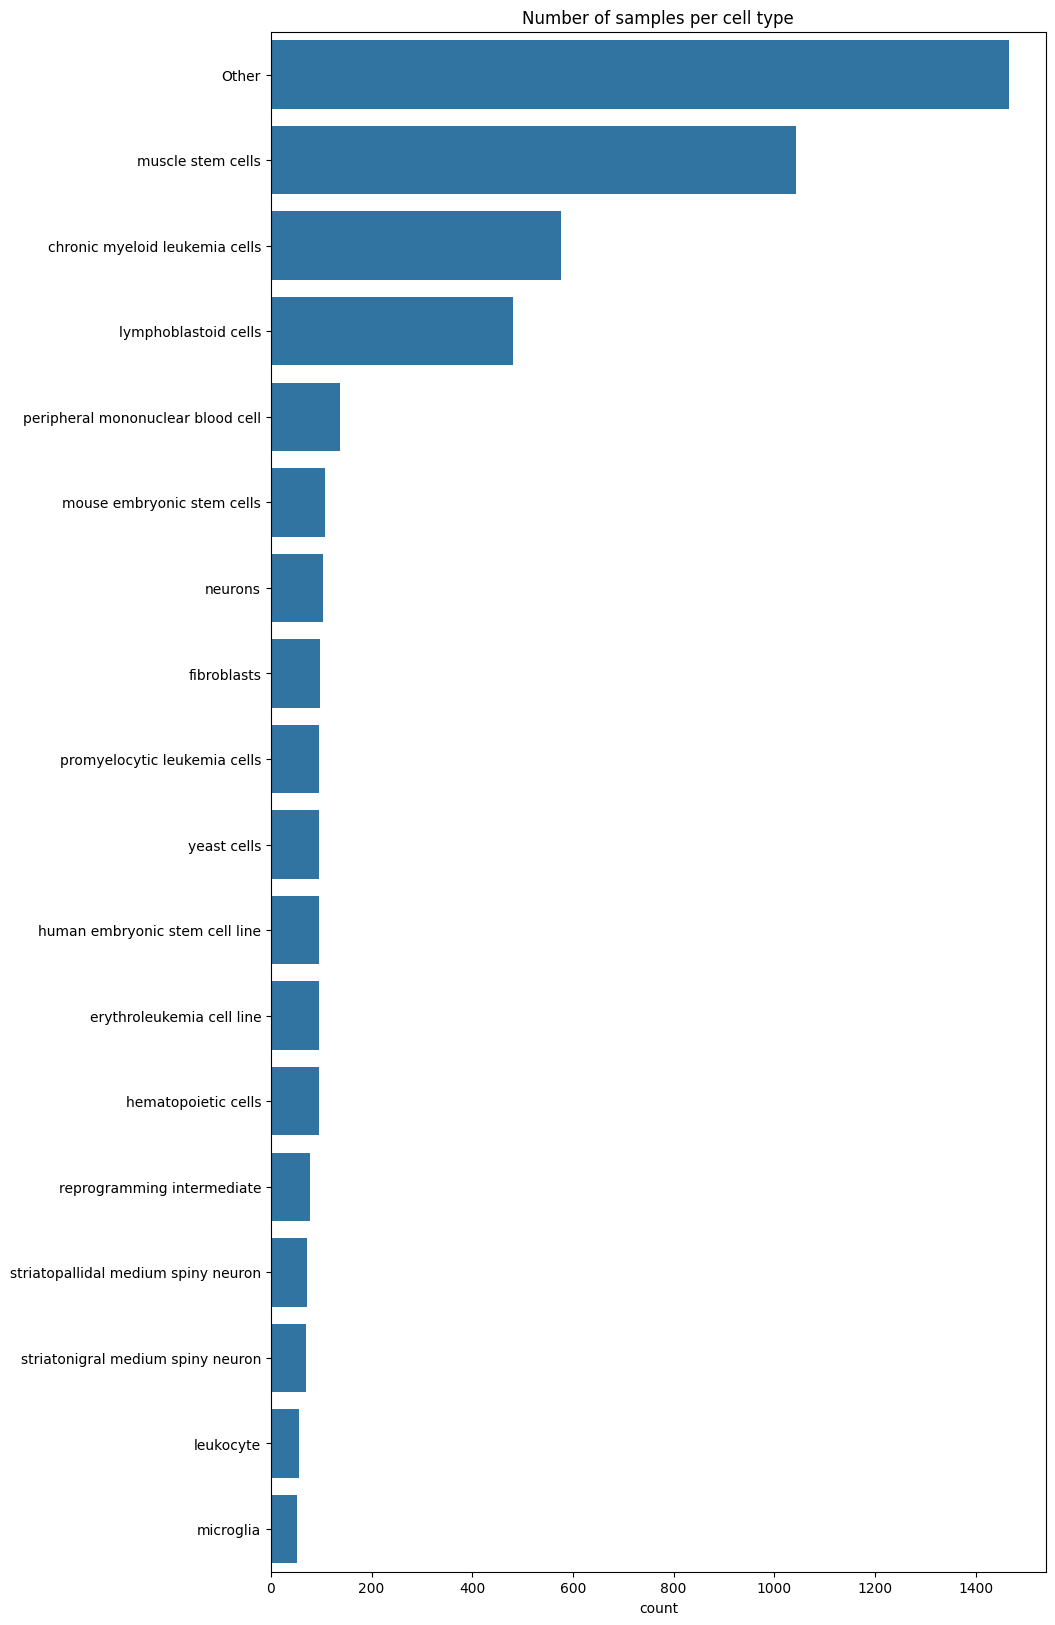

In [31]:
cell_types = pd.Series([sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics])
cell_types_processed = replace_low_frequency_levels_with_other(cell_types, 50)
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(cell_types_processed, ax=ax, order=cell_types_processed.value_counts().index)
ax.set_title("Number of samples per cell type")

There are synonyms here as well.

As a side note, let's see if most samples contain either the tissue type or cell type as both are indicative of the tissue being studied. 

In [32]:
contains_tissue_or_cell_type = [sample for sample in samples if "tissue" in sample.characteristics or "cell type" in sample.characteristics]
n_samples = len(samples)
n_contains = len(contains_tissue_or_cell_type)
print(f"{n_contains}/{n_samples} ({n_contains / n_samples * 100}%) contain tissue information")

20988/44591 (47.06779394945168%) contain tissue information


## Values of other characteristics fields

Time

In [33]:
time_values = [sample.characteristics["time"] for sample in samples if "time" in sample.characteristics]
time_values += [sample.characteristics["time point"] for sample in samples if "time point" in sample.characteristics]
for time in set(time_values):
    print(time)


2 hours
2hrs after the indicated surgery
d0
12 months
24 hours
1 hour
4hrs post exercise
day 5
day 10
basal
6 hours
isolation after 11 days of culture
24 months
isolation after 11 days after transfection
7 hours
control
isolation after 7 days of culture
3 hours
isolation after 21 days of culture
3 months
young adult (d1 of adulthood)
isolation after 14 days of culture
72 h
day 0
d0 (1st day of adulthood)


Age

In [34]:
age_keys = set([key for key in characteristics_keys if "age" in key.split(" ")])
age_values = []
for age_key in age_keys:
    age_values += [sample.characteristics[age_key] for sample in samples if age_key in sample.characteristics]
print("Keys:", age_keys)
for age_value in set(age_values):
    print(age_value)

Keys: {'age'}
53.2
50.8
104 wks
64.2
24 months postnatal
47.3
24.3
61.59
78.26
39.3
8
0-year-old
79
12.6 weeks
6 month
25.3
55.2
22 years
106  years old
84.19
61.1
55.53
54.09
130 wks
57.4
72.96
37 years old
19.7
78.58
48.8
66.4
70.85
49.86
22.5
73.4
50.2
47.6
70.8
60.2
10
75.03
41 years old
73.69
57.68
34.8
55 years
77.5
41 years
31.4
46 years
41.1
2
28.2
70
25.6
68.25
2-3 months old
52.3
23.5
56.7
49.1
12.0 weeks
72.4
43.9
26.7
29.7
11 months
91 years old
57.7
50 years
36.6
36.7
28 days
31.9
85.91
63.54
44.21
old
39.1
60 years
54 years old
young (2-month-old)
28.4
20-month old
70.56
39.6
78.13
25 years
32 years
41.5
60.08
71.6
28.5
3yr9mos
10 months
9 months
38.8
67.29
79.62
69.92
44.6
62.7
64.73
12 years
80.83
36.2
53.4
72.97
73.66
36.9
56.5
29.8
43.7
23 years
54
17
54.2
29.5
83
3 month
105  years old
33.7
78.11
84.95
51.2
46.2
21 months postnatal
60.29
60.4
55.5
32.6
68.95
24 month
60 years old
59.2
51 years old
79.28
63 years
64.7
51.9
55.68
57.41
40.2
young adult
2 month
61 years

## Parsing age fields

Age is usually represented here as a number or range followed by a unit, or just a number.
However there are excpetions to this rule, for example ">60 years old", and they have to be handled differently.
There are also non-numerical descriptions such as Young, Middle and Old which cannot be converted into numbers.

In [35]:
import re
INF_AGE = 999
MIN_AGE = 0


def normalize_to_years(value, unit):
    """Converts age to years based on the unit."""
    unit = unit.lower()
    if unit in ['year', 'years', 'yr', 'yrs', 'y']:
        return float(value)
    elif unit in ['month', 'months', 'mo', 'mos']:
        return float(value) / 12.0
    elif unit in ['week', 'weeks', 'wks', 'wk', 'w']:
        return float(value) / 52.0
    elif unit in ['day', 'days', 'd']:
        return float(value) / 365.0
    return None  # Should not happen if regex is correct


def extract_age(age_str: str):
    """
    Extratcts age in years or a range from a piece of text 
    stating the age or age group.
    If the age cannot be determined, the function returns null.

    :param age_str: Text from which to extract the age
    :returns: A single number containing the age or a pair if a range was detected.
    """
    age_str = str(age_str).lower().strip()  # Normalize text

    if is_number(age_str):
        return float(age_str)  # assume age is in years

    is_age_range, age_range = try_extract_age_range(age_str)
    if is_age_range:
        return age_range

    # Handle 110+
    is_age_plus, age_range = try_extract_age_plus(age_str)
    if is_age_plus:
        return age_range

    # Handle >60
    is_greater_than_age, age_range = try_extract_greater_than_age(age_str)
    if is_greater_than_age:
        return age_range
    
    # Handle <60
    is_less_than_age, age_range = try_extract_less_than_age(age_str)
    if is_less_than_age:
        return age_range

    is_age_plus_unit, age = try_extract_age_plus_unit(age_str)
    if is_age_plus_unit:
        return age

    
    return None


def try_extract_age_range(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-\s*(\d+\.?\d*)\s*(year|yr|month|mo|week|wk|w|day|d)?s?\s*(old)?', age_str)
    if not match:
        return False, None
    val1 = float(match.group(1))
    val2 = float(match.group(2))
    unit = match.group(3)
    if unit:
        return True, (normalize_to_years(val1, unit), normalize_to_years(val2, unit))
    else:
        return True, (val1, val2)  # Assume years


def try_extract_age_plus_unit(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-?\s*(year|yr|month|mo|week|wk|w|day|d)s?\s*-?\s*(old)?', age_str)
    if not match:
        return False, None
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        return True, normalize_to_years(value, unit)


def try_extract_age_plus(age_str: str):
    """
    Tries to extract ages like 110+ out of the text.
    """
    match = re.search(r'(\d+)\+', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_greater_than_age(age_str: str):
    """
    Tries to extract ages like >20 out of the text.
    """
    match = re.search(r'\>(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_less_than_age(age_str: str):
    """
    Tries to extract ages like <20 out of the text.
    """
    match = re.search(r'\<(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (MIN_AGE, float(match.group(1)))


def is_number(text):
    try:
        float(text)
        return True
    except:
        return False

In [36]:
for age in set(age_values):
    print(age, extract_age(age))

53.2 53.2
50.8 50.8
104 wks 2.0
64.2 64.2
24 months postnatal 2.0
47.3 47.3
24.3 24.3
61.59 61.59
78.26 78.26
39.3 39.3
8 8.0
0-year-old 0.0
79 79.0
12.6 weeks 0.2423076923076923
6 month 0.5
25.3 25.3
55.2 55.2
22 years 22.0
106  years old 106.0
84.19 84.19
61.1 61.1
55.53 55.53
54.09 54.09
130 wks 2.5
57.4 57.4
72.96 72.96
37 years old 37.0
19.7 19.7
78.58 78.58
48.8 48.8
66.4 66.4
70.85 70.85
49.86 49.86
22.5 22.5
73.4 73.4
50.2 50.2
47.6 47.6
70.8 70.8
60.2 60.2
10 10.0
75.03 75.03
41 years old 41.0
73.69 73.69
57.68 57.68
34.8 34.8
55 years 55.0
77.5 77.5
41 years 41.0
31.4 31.4
46 years 46.0
41.1 41.1
2 2.0
28.2 28.2
70 70.0
25.6 25.6
68.25 68.25
2-3 months old (0.16666666666666666, 0.25)
52.3 52.3
23.5 23.5
56.7 56.7
49.1 49.1
12.0 weeks 0.23076923076923078
72.4 72.4
43.9 43.9
26.7 26.7
29.7 29.7
11 months 0.9166666666666666
91 years old 91.0
57.7 57.7
50 years 50.0
36.6 36.6
36.7 36.7
28 days 0.07671232876712329
31.9 31.9
85.91 85.91
63.54 63.54
44.21 44.21
old None
39.1 39.1
60

## Grouping tissues

In [37]:
import scispacy.linking_utils

def create_without_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database.
    """
    nlp = spacy.load("en_core_sci_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp

def create_entity_linking_pipeline_with_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database
    that also performs named entity recognition.
    """
    nlp = spacy.load("en_ner_bionlp13cg_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp


def link_entities(nlp, document: str) -> List[scispacy.linking_utils.Entity]:
    """
    Links entities in the document to the knowledge base of the scicpacy pipeline 
    and returns the canonical names and match scores.

    :param nlp: Scispacy NLP pipeline for entity linking and named entity
    recognition (see create_entity_linking_pipeline).
    :param document: The document in which to link entities to UMLS.
    :returns: A list of tuples (entity, canonical_name, score, label) where:
        1. entity is the name of the entity as it appears in the text.
        2. canonical_name is the canonical name of the entity in the knowledge base.
        3. score is the score of the knowledge base match. 
        4. NER label of the entity (e.g. ORGANISM, CELL, ...) 
        If an entity does not exist in the knowledge base it will be returned as (entity, entity, -1, None).
    """
    processed_doc = nlp(document)
    linker = nlp.get_pipe("scispacy_linker")
    knowledge_base = linker.kb
    all_links = []
    for ent in processed_doc.ents:
        if not ent._.kb_ents:
            all_links.append((ent, ent, -1, ent.label_))
            continue

        concept_id, score = ent._.kb_ents[0]
        umls_entity = knowledge_base.cui_to_entity[concept_id]
        canonical_name = umls_entity.canonical_name
        entity_link = (ent, canonical_name, score, ent.label_)
        all_links.append(entity_link)
            
    return all_links

def get_canonical_name(nlp, tissue: str):
    entity_links = link_entities(nlp, tissue)
    if not entity_links:
        return (tissue, tissue, -1)

    relevant_labels = ["CELL", "TISSUE", "ORGAN", "PATHOLOGICAL_FORMATION"]
    relevant_links = list(filter(lambda link: link[3] in relevant_labels, entity_links))
    if relevant_links:
        return max(relevant_links, key=lambda link: link[2])[:3] # Return link with the highest score
    return max(entity_links, key=lambda link: link[2])[:3]


In [38]:
nlp = create_entity_linking_pipeline_with_ner(knowledge_base="umls")

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


{"asctime": "2025-06-11 17:32:12,688", "levelname": "INFO", "message": "Loading index from /home/Momir.Milutinovic/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin"}
{"asctime": "2025-06-11 17:32:12,689", "levelname": "INFO", "message": "Loading regular index."}
{"asctime": "2025-06-11 17:32:20,303", "levelname": "INFO", "message": "Finished loading index"}
{"asctime": "2025-06-11 17:32:20,304", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-11 17:32:20,304", "levelname": "INFO", "message": "ef(Search)         =20"}
{"asctime": "2025-06-11 17:32:20,305", "levelname": "INFO", "message": "algoType           =2"}
{"asctime": "2025-06-11 17:32:20,305", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-11 17:32:20,306", "levelname": "INFO", "message": "ef(Search)         =200"}
{"asctime": "2025-06

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [39]:

unique_tissues = list(set(tissues))
 
entity_links_ner = [get_canonical_name(nlp, tissue) for tissue in unique_tissues]
for entity, canonical_name, score in entity_links_ner:
    print ("Entity:", entity)
    print ("Score:", score)
    print ("Cannonical name:", canonical_name)
    print("------")


Entity: bone marrow
Score: 1.0
Cannonical name: Bone Marrow
------
Entity: gastric
Score: 1.0
Cannonical name: Stomach
------
Entity: whole body of group-housed males at 35 dph
Score: -1
Cannonical name: whole body of group-housed males at 35 dph
------
Entity: fetal limb
Score: 1.0
Cannonical name: Fetal limb
------
Entity: entorhinal cortex
Score: 1.0
Cannonical name: Structure of entorhinal cortex
------
Entity: whole body of group-housed females at 28 dph
Score: -1
Cannonical name: whole body of group-housed females at 28 dph
------
Entity: gut
Score: -1
Cannonical name: gut
------
Entity: musculus vastus lateralis
Score: 1.0
Cannonical name: Structure of vastus lateralis muscle
------
Entity: ovary
Score: 1.0
Cannonical name: Ovary
------
Entity: non-tumor liver tissue
Score: 0.8217506408691406
Cannonical name: Non-Tumor Tissue Area
------
Entity: brown adipose tissue
Score: 1.0
Cannonical name: Brown Fat
------
Entity: mouse spleen
Score: 1.0
Cannonical name: Mouse Spleen
------


### Scispacy vs LLM

In [40]:
tissue_standardization_df_dict = {
    "entity": unique_tissues,
    "scispacy_name": [link[1] for link in entity_links_ner],
    "llm_name": [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in unique_tissues]
}
tissue_naming_df = pd.DataFrame(tissue_standardization_df_dict)
pd.set_option('display.max_rows', None)
tissue_naming_df

,entity,scispacy_name,llm_name
0,adult bone marrow,Bone Marrow,adult bone marrow
1,gastric surrounding normal tissue,Stomach,gastric surrounding normal tissue
2,whole body of group-housed males at 35 dph,whole body of group-housed males at 35 dph,whole body of group-housed males at 35 dph
3,fetal limb,Fetal limb,fetal limb
4,entorhinal cortex,Structure of entorhinal cortex,entorhinal cortex
5,whole body of group-housed females at 28 dph,whole body of group-housed females at 28 dph,whole body of group-housed females at 28 dph
6,gut,gut,gut
7,musculus vastus lateralis,Structure of vastus lateralis muscle,musculus vastus lateralis
8,ovary,Ovary,ovary
9,adjacent non-tumor liver tissue,Non-Tumor Tissue Area,adjacent non-tumor liver tissue


### NER vs no NER

In [41]:
nlp_no_ner = create_without_ner()

{"asctime": "2025-06-11 17:33:14,478", "levelname": "INFO", "message": "Loading index from /home/Momir.Milutinovic/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin"}
{"asctime": "2025-06-11 17:33:14,480", "levelname": "INFO", "message": "Loading regular index."}
{"asctime": "2025-06-11 17:33:21,980", "levelname": "INFO", "message": "Finished loading index"}
{"asctime": "2025-06-11 17:33:21,981", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-11 17:33:21,982", "levelname": "INFO", "message": "ef(Search)         =20"}
{"asctime": "2025-06-11 17:33:21,983", "levelname": "INFO", "message": "algoType           =2"}
{"asctime": "2025-06-11 17:33:21,983", "levelname": "INFO", "message": "Set HNSW query-time parameters:"}
{"asctime": "2025-06-11 17:33:21,984", "levelname": "INFO", "message": "ef(Search)         =200"}
{"asctime": "2025-06

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [42]:
entity_links_no_ner = [get_canonical_name(nlp_no_ner, tissue) for tissue in unique_tissues]
tissue_standardization_df_dict = {
    "entity": unique_tissues,
    "name with ner": [link[1] for link in entity_links_ner],
    "name without ner": [link[1] for link in entity_links_no_ner],
}
tissue_naming_df = pd.DataFrame(tissue_standardization_df_dict)
pd.set_option('display.max_rows', None)
tissue_naming_df

,entity,name with ner,name without ner
0,adult bone marrow,Bone Marrow,Adult
1,gastric surrounding normal tissue,Stomach,Stomach
2,whole body of group-housed males at 35 dph,whole body of group-housed males at 35 dph,Males
3,fetal limb,Fetal limb,Fetal limb
4,entorhinal cortex,Structure of entorhinal cortex,Structure of entorhinal cortex
5,whole body of group-housed females at 28 dph,whole body of group-housed females at 28 dph,Females
6,gut,gut,Gastrointestinal tract structure
7,musculus vastus lateralis,Structure of vastus lateralis muscle,Structure of vastus lateralis muscle
8,ovary,Ovary,Ovary
9,adjacent non-tumor liver tissue,Non-Tumor Tissue Area,Adjacent


## Parsing cell types

In [43]:
cell_types = [sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics]
unique_cell_types = list(set(cell_types))

In [44]:
entity_links_cell_types = [get_canonical_name(nlp, cell_type) for cell_type in unique_cell_types]
cell_standardization_df_dict = {
    "Entity": unique_cell_types,
    "Name with NER": [link[1] for link in entity_links_cell_types],
}
cell_naming_df = pd.DataFrame(cell_standardization_df_dict)
pd.set_option('display.max_rows', None)
cell_naming_df

,Entity,Name with NER
0,endothelial cells,Endothelial Cells
1,minsc,minsc
2,hepatic cell line,Hepatocyte
3,mesenchymal stromal cells,Mesenchymal Stromal Cells
4,hematopoietic cells,Hematopoietic stem cells
5,common lymphoid progenitor (clp),Lymphoid Progenitor Cells
6,primary astrocytes,Astrocytes
7,t lymphocyte cells,B-Lymphocytes
8,"mixed sample (non-demultiplexed) of ec, fb, and mp","mixed sample (non-demultiplexed) of ec, fb, and mp"
9,hematopoietic stem cell (hsc),Hematopoietic stem cells


## Comparison between the Gilda-scispacy combined parser and the purely scispacy parser

In [45]:
from src.tissue_and_cell_type_standardization.get_standard_name import get_standard_name
from src.tissue_and_cell_type_standardization.is_mesh_term_in_anatomy_or_disease import build_mesh_lookup
mesh_lookup = build_mesh_lookup("desc2025.xml")

Building MeSH lookup from 'desc2025.xml'...
Lookup built successfully. Found 265680 unique terms.


### Tissue names

In [ ]:
tissue_naming_df["gilda_name"] = tissue_naming_df["entity"].apply(get_standard_name, mesh_lookup=mesh_lookup, nlp=nlp)
tissue_naming_df[["entity", "name with ner", "gilda_name"]]

,entity,name with ner,gilda_name
0,adult bone marrow,Bone Marrow,Bone Marrow
1,gastric surrounding normal tissue,Stomach,Stomach
2,whole body of group-housed males at 35 dph,whole body of group-housed males at 35 dph,whole body of group-housed males at 35 dph
3,fetal limb,Fetal limb,Extremities
4,entorhinal cortex,Structure of entorhinal cortex,Entorhinal Cortex
5,whole body of group-housed females at 28 dph,whole body of group-housed females at 28 dph,whole body of group-housed females at 28 dph
6,gut,gut,gut
7,musculus vastus lateralis,Structure of vastus lateralis muscle,Structure of vastus lateralis muscle
8,ovary,Ovary,Ovary
9,adjacent non-tumor liver tissue,Non-Tumor Tissue Area,Liver


In [59]:
cell_naming_df["gilda_name"] = cell_naming_df["Entity"].apply(get_standard_name, mesh_lookup=mesh_lookup, nlp=nlp)
cell_naming_df[["Entity", "Name with NER", "gilda_name"]]

,Entity,Name with NER,gilda_name
0,endothelial cells,Endothelial Cells,Endothelial Cells
1,minsc,minsc,minsc
2,hepatic cell line,Hepatocyte,Hepatocytes
3,mesenchymal stromal cells,Mesenchymal Stromal Cells,Stromal Cells
4,hematopoietic cells,Hematopoietic stem cells,Hematopoietic stem cells
5,common lymphoid progenitor (clp),Lymphoid Progenitor Cells,Lymphoid Progenitor Cells
6,primary astrocytes,Astrocytes,Astrocytes
7,t lymphocyte cells,B-Lymphocytes,Lymphocytes
8,"mixed sample (non-demultiplexed) of ec, fb, and mp","mixed sample (non-demultiplexed) of ec, fb, and mp",Epidermal Cells
9,hematopoietic stem cell (hsc),Hematopoietic stem cells,Hematopoietic Stem Cells


# Filtering datasets

## Retrieve by age range

In [47]:


def do_ranges_overlap(range1: Tuple[float, float], range2: Tuple[float, float]) -> bool:
    return range1[0] <= range2[1] and range2[0] <= range1[1]


def is_sample_in_age_range(sample: GEOSample, age_range: Tuple[float, float]) -> bool:
    """
    Returns true if a sample's age falls into the age range (inclusive).

    :param sample: GEO sample whose age to check.
    :param age_range: Age range (from, to).
    :return: True if age is in range, false if it is not. If the
    sample does not have an age key, the function returns false.
    """
    age = sample.characteristics.get("age") or sample.characteristics.get(
        "age (yr)") or sample.characteristics.get("age (years)")
    if not age:
        return False
    age = extract_age(age)

    if isinstance(age, float):
        return age_range[0] < age < age_range[1]
    elif isinstance(age, Tuple):
        return do_ranges_overlap(age, age_range)
    elif age is None:
        return False # Cannot compare qualitative ages
    else:
        raise ValueError(f"Extracted age is of unexpected type: {type(age)}")


def dataset_has_sample_in_age_range(dataset: GEODataset, age_range: Tuple[float, float]) -> float:
    """
    Returns true if a dataset contains a sample whose age
    falls into the age range (inclusive).

    :param dataset: Dataset in which to check if it contains a sample
    of the desired age.
    :param age_range: Age range (from, to).
    :return: True if the sample contains a sample whose age is in the
    given age range, otherwise False.
    """
    return any(
        [is_sample_in_age_range(sample, age_range)
         for sample in dataset.samples]
    )


def filter_by_age_range(datasets: List[GEODataset], age_range: Tuple[float, float]):
    """
    Retrieves datasets that have samples whose age falls into the age range (inclusive).

    :param datasets: List of GEO Datasests/Series to search by age.
    :age_range: Tuple containing the age range to search for (from, to).
    :return: List of GEO datasets which contain samples that fall into the
    desired age range.
    """
    return list(filter(lambda d: dataset_has_sample_in_age_range(d, age_range), datasets))

In [48]:
for d in filter_by_age_range(datasets, (18, 30)):
    print(d.id)


GSE116250
GSE202601
GSE120221
GSE84727
GSE76427
GSE178824
GSE235717
GSE233087
GSE130991
GSE167523
GSE242202
GSE226636
GSE21935
GSE147221
GSE30352
GSE30337
GSE125105
GSE133747
GSE136831
GSE17612
GSE212109
GSE152026
GSE109816
GSE201118
GSE80417
GSE121893
GSE275442
GSE182786
GSE87571
GSE113957
GSE165192
GSE80672
GSE53890
GSE164056


## Filter by presence of characteristic

In [49]:
def filter_by_has_characteristic(datasets: List[GEODataset], characteristic: List[str]):
    """
    Retrieves datasets that contain a sample that for which the given characteristic
    is specified.

    :param datasets: List of datasets to filter.
    :param characteristic: The characteristic the samples must have.
    :return: List of datasets which contain a sample that has the specified charcteristic.
    """
    return list(filter(
        lambda dataset: any(
            [characteristic in sample.characteristics for sample in dataset.samples]
        ),
        datasets
    ))

Let's see which datasets have sarcopenia status specified.

In [50]:
sarcopenia_datasets = filter_by_has_characteristic(datasets, "sarcopenia status")
for dataset in sarcopenia_datasets:
    print(dataset.id)
    print(dataset)

GSE111016
Study of sarcopenia in human muscle biopsies of elderly individuals, Singapore Sarcopenia Study
Expression profiling by high throughput sequencing
Purpose: The main goal of this study is to compare skeletal muscle transcriptome profilings derived from sarcopenic versus healthy subjects.
Homo sapiens
20 muscle biopsies from healthy subjects and 20 muscle biopsies from sarcopenic subjects.
GSE111017
Study of sarcopenia in human muscle biopsies of elderly individuals
Expression profiling by high throughput sequencing
Homo sapiens


Next, we will check out the composition of the samples.

In [51]:
def extract_characteristic_values(samples: List[GEOSample], characteristic: str):
    return[sample.characteristics[characteristic] for sample in samples if characteristic in sample.characteristics]


In [52]:
sarcopenia_samples = [sample for dataset in sarcopenia_datasets for sample in dataset.samples]
sarcopenia_samples = list(set(sarcopenia_samples)) # We need to remove duplicates because the first dataset is a superseries containing the second series
sarcopenia_statuses = extract_characteristic_values(sarcopenia_samples, "sarcopenia status")
sarcopenia_sample_sexes = extract_characteristic_values(sarcopenia_samples, "Sex")
sarcopenia_statuses = pd.Series(sarcopenia_statuses)
sarcopenia_sample_sexes = pd.Series(sarcopenia_sample_sexes)
print ("Sarcopenia status of the samples in the sarcopenia study")
print(sarcopenia_statuses.value_counts())
print ("Sexes of the samples in the sarcopenia study")
print(sarcopenia_sample_sexes.value_counts())

Sarcopenia status of the samples in the sarcopenia study
no     86
yes    33
Name: count, dtype: int64
Sexes of the samples in the sarcopenia study
Series([], Name: count, dtype: int64)


## Filter by publication date

In [53]:
def filter_by_publication_date(datasets: List, date_range: Tuple[datetime.datetime, datetime.datetime]):
    return filter(lambda d: date_range[0] <= d.publication_date <= date_range[1], datasets)

In [54]:
for dataset in filter_by_publication_date(datasets, (datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31))):
    print(dataset.id)
    print(dataset)

GSE157099
Memory-induced transcriptome in Huntington's disease (HD) mice [RNA-seq]
Expression profiling by high throughput sequencing
Evaluation of the effect of procedural  memory using the double-H maze (DH) on striatal and hippocampal transcriptome in HD R6/1 mice
Mus musculus
RNAseq data were generated using the striatum of WT and HD mice in resting condition (home cage, HC), during memory formation (after 2 days of training in the double H maze, DH-2d) and during memory consolidation/recall (after the probe test performed after 4 days of training, DH-5d)
GSE157783
Single cell atlas of the human midbrain reveals cell state specific to Parkinson’s disease
Expression profiling by high throughput sequencing
Using single-nucleus RNA sequencing, we profiled postmortem midbrain tissue from Idiopathic Parkinson’s Disease patients and matched controls.
Homo sapiens
Single-cell transcriptomics of postmortem midbrain of six control and five idiopathic Parkinson's disease cases
GSE147672
Sing